In [3]:
import torchvision
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.mobilenetv3 import MobileNet_V3_Large_Weights
import os

model = ssdlite320_mobilenet_v3_large(weights=None, num_classes=3,  weights_backbone=MobileNet_V3_Large_Weights.DEFAULT) # we do not specify pretrained=True, i.e. do not load default weights
#model.load_state_dict(torch.load(''))




checkpoint = torch.load("Results/Models/model_opt_adam_epochs_50_train_backbone_True_lr_0.001_lrstepsize_8_lrgamma_0.1_mom_0.9_final.pth")
model.load_state_dict(checkpoint['model'])


# set the device (GPU is much faster)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

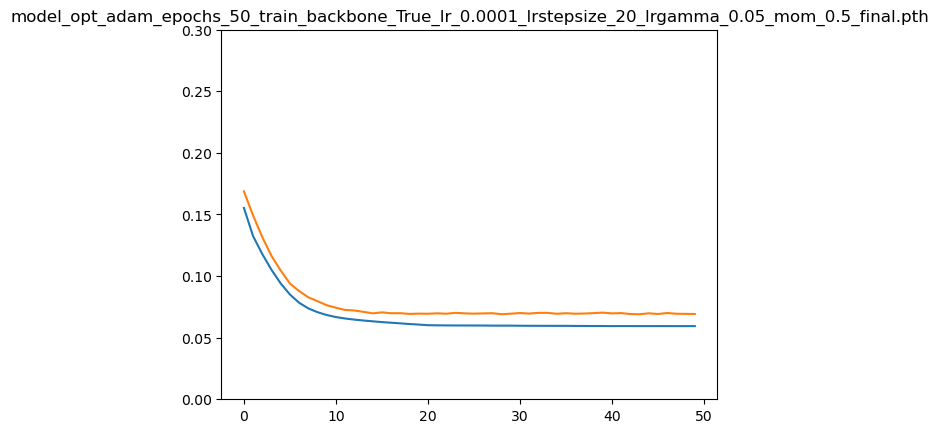

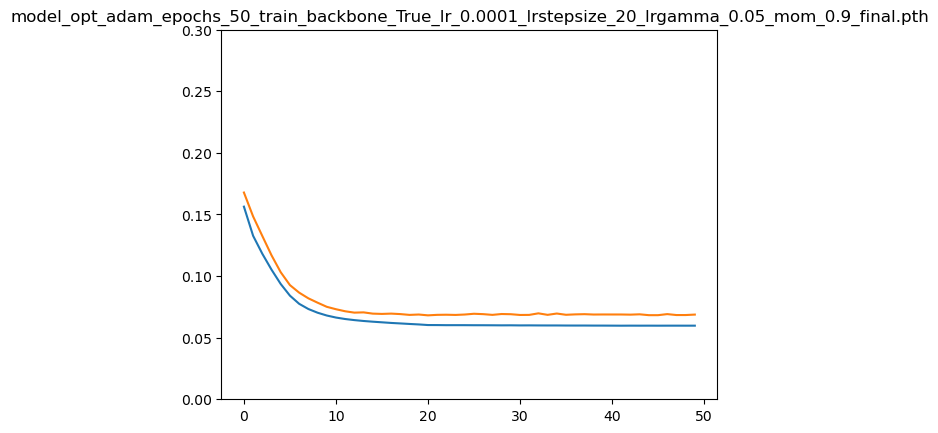

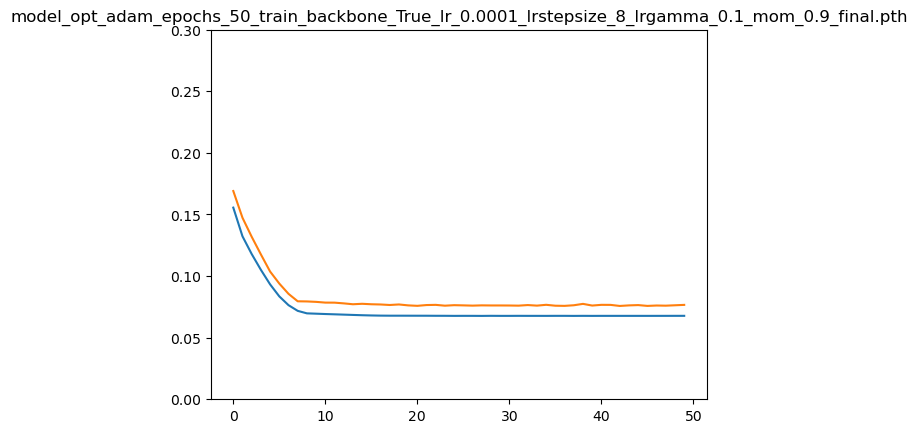

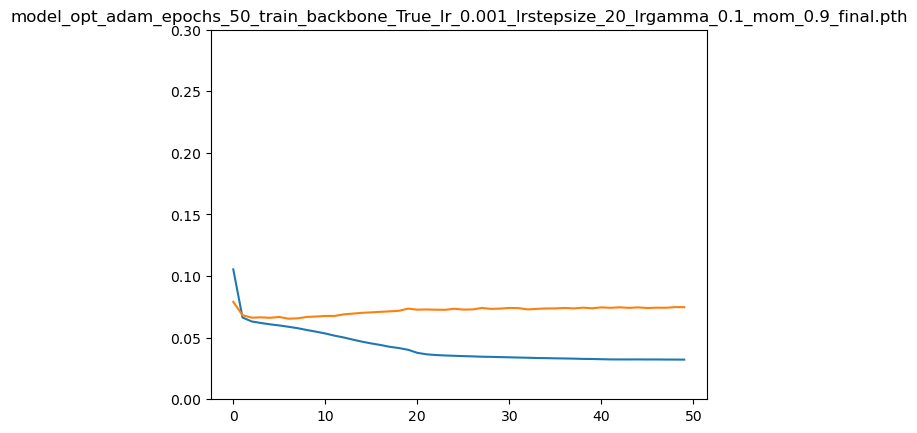

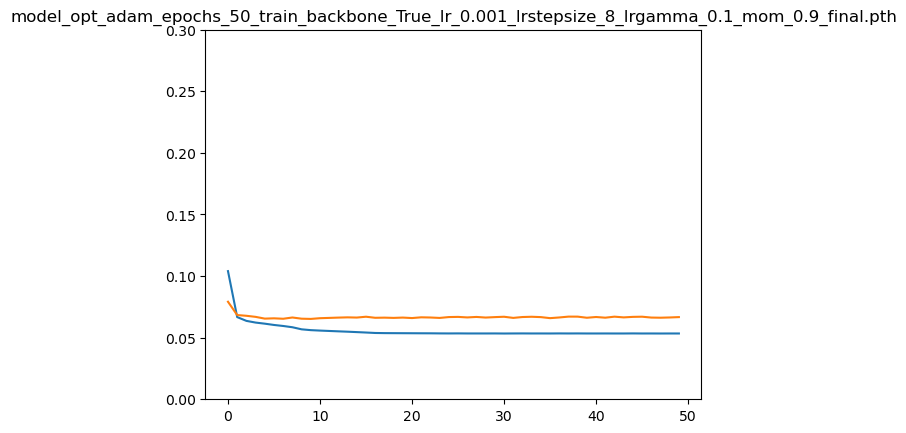

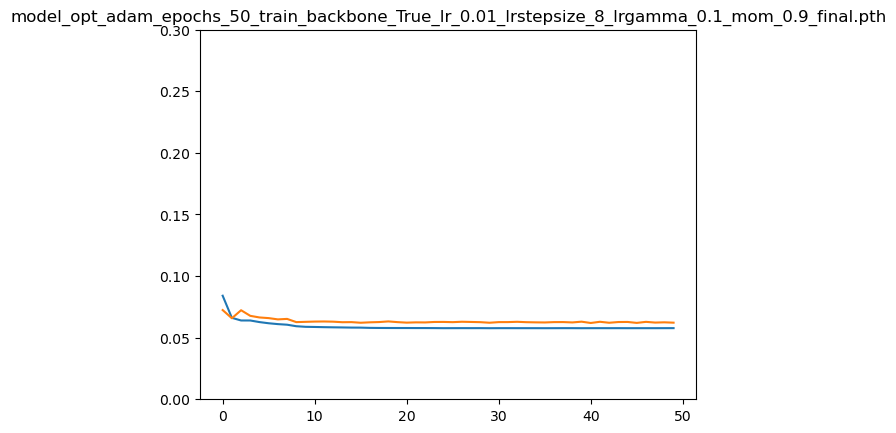

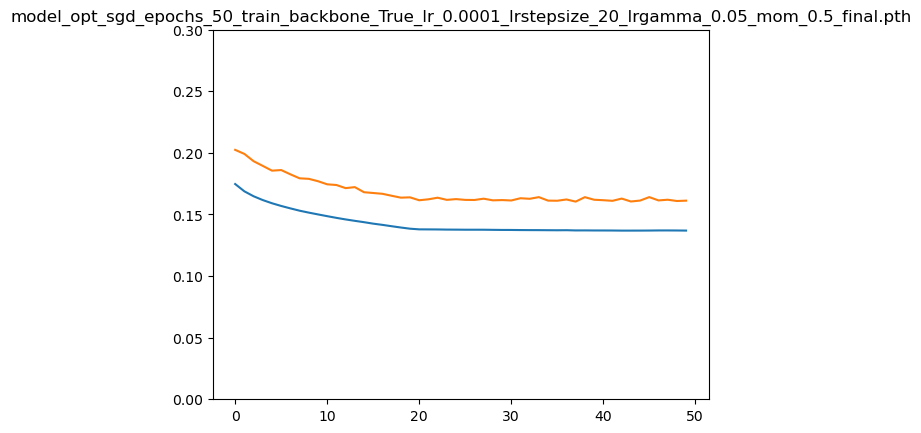

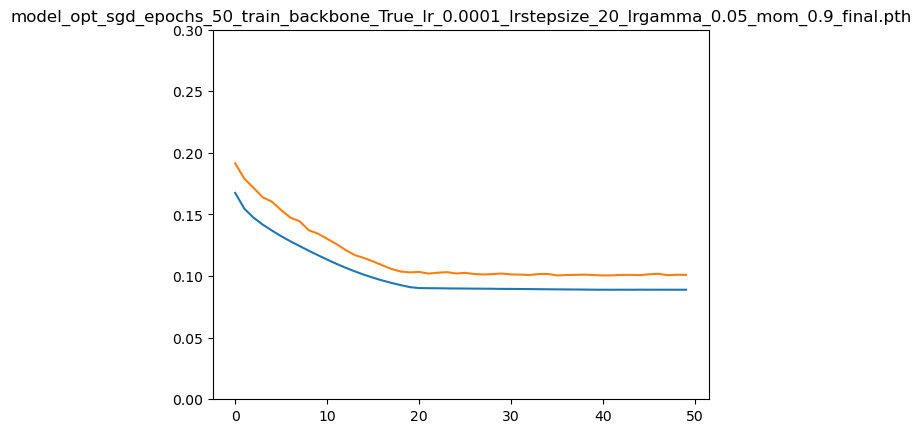

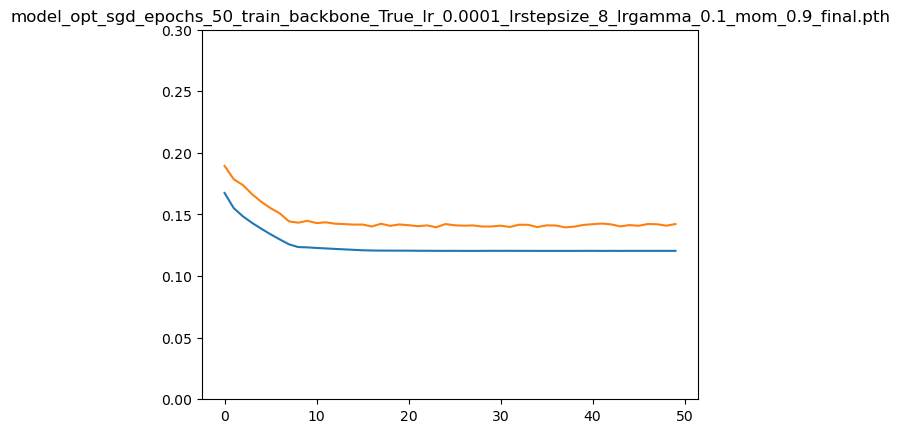

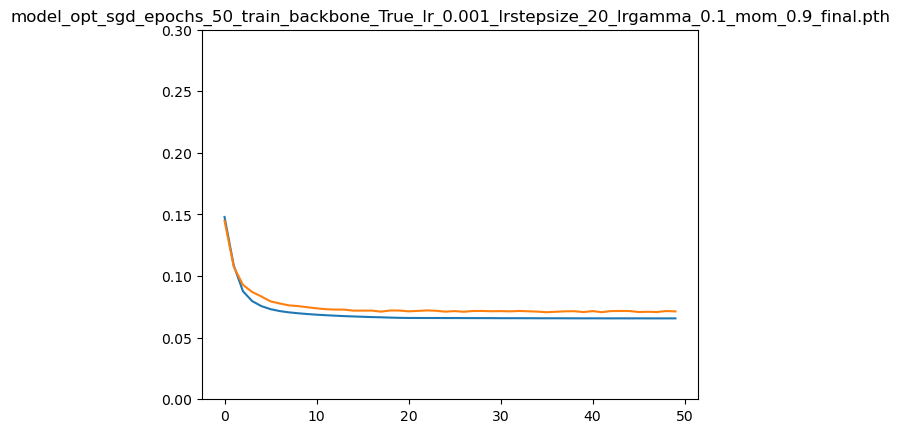

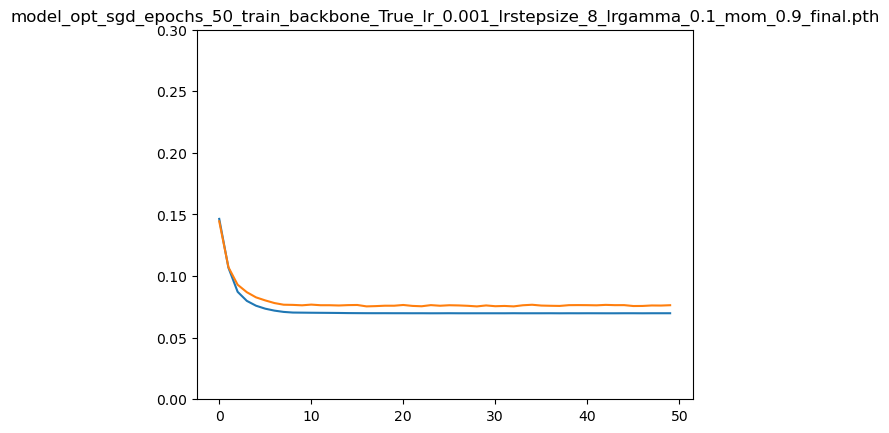

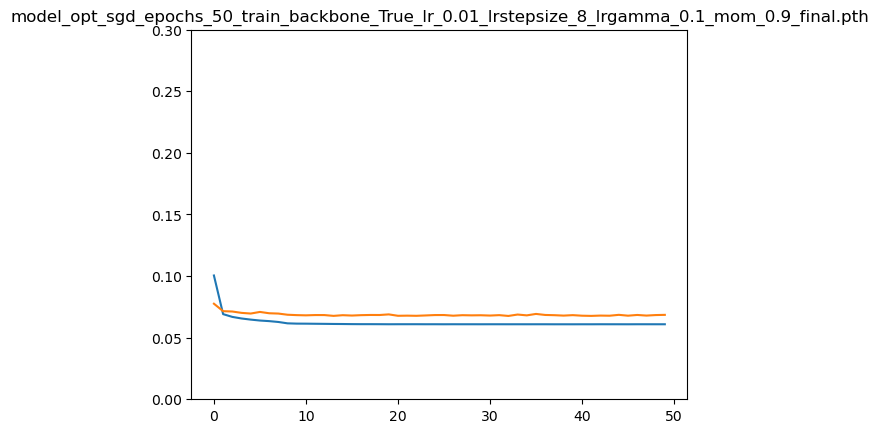

In [13]:
import matplotlib.pyplot as plt

model = ssdlite320_mobilenet_v3_large(weights=None, num_classes=3, weights_backbone=None) # we do not specify pretrained=True, i.e. do not load default weights

modelsFolder = "Results/Models"

for modelFile in os.listdir(modelsFolder):
    path = os.path.join(modelsFolder, modelFile)
    checkpoint = torch.load(path)

    #model.load_state_dict(checkpoint['model'])

    plt.plot(checkpoint["losses_train"])
    plt.plot(checkpoint["losses_val"])
    plt.title(modelFile)
    plt.ylim((0, 0.3))
    plt.show()

In [45]:
from torch.utils.data import DataLoader
from src.dataLoading import playersDataset, collate_fn   # these are custom for our dataset




num_workers = 1 if torch.cuda.is_available() else 0
batch_size = 1 # LOWER THIS IF NEEDED!

train_dir = "Data/train/"
valid_dir = "Data/valid/"
test_dir = "Data/valid/"
train_dataset = playersDataset(train_dir)
validation_dataset = playersDataset(valid_dir)
test_dataset = playersDataset(test_dir)

# Define the dataloaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [47]:
from Evaluation.engine import evaluate


#evaluate(model=model, data_loader=test_loader, device=device)

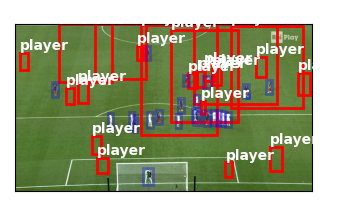

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Colours = ['r','g','b']

def visualize_imgs(imgs, annotations, true_annotations, rows, cols, threshold, tensors=False):
    CLASSES = ["","ball", "player"]
    fig = plt.figure(figsize=(20,10))
    
    for i in range(len(imgs)):
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])

        boxes = annotations[i]['boxes']
        true_boxes = true_annotations[i]['boxes']
        labels = annotations[i]['labels']
        scores = annotations[i]['scores']
        
        img = None



        if(tensors):
            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
        else:
            img = imgs[i].numpy().transpose(1, 2, 0)
        ax.imshow(img, origin='upper')

        for j, (box, score, label) in enumerate(zip(boxes, scores,labels)):
            if(score < threshold):
                continue
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='r', facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')
        
        for j, box in enumerate(true_boxes):
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='b', alpha=0.3, facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            # ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')

    plt.show()


model.eval()
images, targets = next(iter(test_loader))
images = list(image.to(device) for image in images)
preds = model(images)

threshold = 0.4

fig = visualize_imgs(images, preds, targets, rows=4, cols=4, threshold = threshold, tensors=True)